# 通过tensorflow autoencoder 计算相似性的例子

首先引入相关的类库

In [14]:
import math

import numpy

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0-dev20191009


基准数据将会采用正弦函数生成，范围是-π至π，值在-1至1之间。因为是正弦函数，所以可视化出来是一个波形

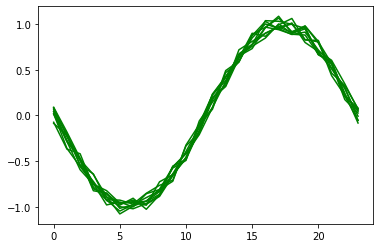

In [15]:
xrange = tf.linspace(-math.pi, math.pi, 24)
baseline_data = tf.math.sin(xrange)

def get_data():
    return tf.map_fn(lambda e: e + numpy.random.uniform(-0.1, 0.1), baseline_data)

# 生成10条数据观察一下，因为加入了-0.1至0.1的随机误差，所以并不平滑
for i in range(10):
    plt.plot(get_data(), color="green")

plt.show()

定义模型

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[24]),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(24)
    ])
    
    optimizer = tf.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [17]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_7 (Dense)              (None, 24)                792       
Total params: 2,664
Trainable params: 2,664
Non-trainable params: 0
_________________________________________________________________


开始训练模型，随机生成2000个数列

In [18]:
DATA_AMOUNT = 2000

In [19]:
input_data = numpy.zeros(shape=(DATA_AMOUNT, 24))
for i in range(DATA_AMOUNT):
    input_data[i] = get_data()
    
input_data.shape
print(input_data[:2])

[[ 0.02825498 -0.2633287  -0.443165   -0.78420317 -0.893134   -1.07144475
  -0.90604907 -0.84613472 -0.84003252 -0.63897407 -0.39933649 -0.16513838
   0.06391621  0.34235266  0.55603045  0.7682578   0.92311352  1.0707016
   0.97395062  0.9796778   0.63484406  0.50850564  0.30601564  0.06310603]
 [ 0.05756824 -0.27655318 -0.44604793 -0.75453621 -0.84560335 -0.90251237
  -1.02176952 -0.95129329 -0.74776208 -0.70261508 -0.31548357 -0.05020395
   0.15144067  0.44389126  0.73028082  0.74673867  0.8909682   1.00603616
   0.9405731   0.96686387  0.7908299   0.61643261  0.33096996  0.0098463 ]]


开始训练

In [20]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 15

history = model.fit(
  input_data, input_data,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


...............

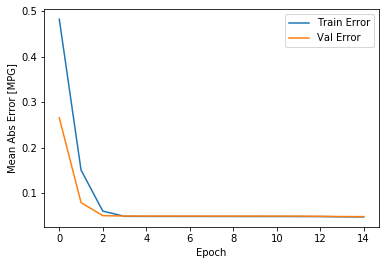

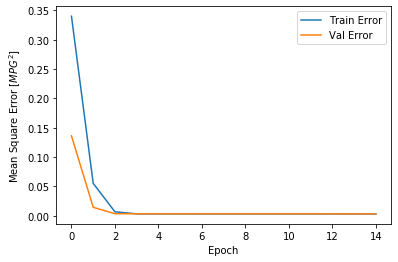

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

加载测试数据，数据又不同程度的修改，例如
1. 改变个别几个点的值
2. 改变波峰和波谷的位置

预期改变越大，loss应该越大

In [22]:
test_data = numpy.loadtxt("sine-based-test-data.csv", delimiter=',')

print(test_data[:2])

test_prediction = model.predict(test_data)

[[-0.02933731 -0.32642642 -0.60788834 -0.72397864 -0.97547996 -0.9415378
  -1.0159543  -0.91429764 -0.89873546 -0.7082084  -0.34106407 -0.09575787
   0.18419927  0.33925903  0.54406685  0.87100095  0.87787116  0.9199926
   1.055753    0.8475192   0.747532    0.47048718  0.26311573 -0.06118441]
 [-0.92933731 -0.82642642 -0.60788834 -0.72397864 -0.97547996 -0.9415378
  -1.0159543  -0.91429764 -0.89873546 -0.7082084  -0.34106407 -0.09575787
   0.18419927  0.33925903  0.54406685  0.87100095  0.87787116  0.9199926
   1.055753    0.8475192   0.747532    0.47048718  0.26311573 -0.06118441]]


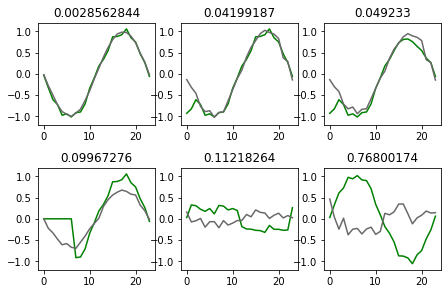

In [23]:
mse = tf.keras.losses.MeanSquaredError()

fig = plt.figure()

for i in range(len(test_data)):
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text(str(mse(test_data[i], test_prediction[i]).numpy()))
    ax.set_ylim([-1.2, 1.2])
    ax.plot(test_data[i], color="green")
    ax.plot(test_prediction[i], color="dimgray")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.show()

通过可视化大致可以看出
1. 相似的曲线loss比较小，反之比较大
2. 改变了波峰波谷的位置，loss大于了0.6

达到了目的